<a href="https://colab.research.google.com/github/Michwynn/Capstone-Team-Air-/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings # supress warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# machine learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# deep learning
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# feature importance
try:
  import shap
except:
  !pip install shap
  import shap

# mounting on google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Capstone

pd.set_option('display.max_columns', None)

# random seed 
RANDOM_SEED = 44

**import files**

In [ ]:
train_df = pd.read_csv("./assets/cleaned_assets/train_df.csv", index_col = 0)
val_df = pd.read_csv("./assets/cleaned_assets/val_df.csv", index_col = 0)
test_df = pd.read_csv("./assets/cleaned_assets/test_df.csv", index_col = 0)

**Split into x_train & y_train, X_val & y_val and X_test & y_test**

In [49]:
outcome_vars = ['price', 'log_price']

X_train = train_df[train_df.columns.difference(outcome_vars)]
y_train = list(train_df.log_price)

X_val = val_df[val_df.columns.difference(outcome_vars)]
y_val = list(val_df.log_price)

X_test = test_df[test_df.columns.difference(outcome_vars)]
y_test = list(test_df.log_price)

**Baseline model - Using Statsmodel for multiple regression**

In [50]:
# prevent dummy variable trap for linear regression
baseline_vars = ['City of London', 
                 'host_has_profile_pic_f', 
                 'host_identity_verified_f', 
                 'Entire home', 
                 'Entire home/apt (room type)']

# drop in all splitted dfs
train_df_reference = train_df.drop(baseline_vars, axis=1)
val_df_reference = val_df.drop(baseline_vars, axis=1)
test_df_reference = test_df.drop(baseline_vars, axis=1)

X_train_reference = train_df_reference[train_df_reference.columns.difference(outcome_vars)]
y_train_reference = list(train_df.log_price)

X_val_reference = val_df_reference[val_df_reference.columns.difference(outcome_vars)]
y_val_reference = list(val_df_reference.log_price)

X_test_reference = test_df_reference[test_df_reference.columns.difference(outcome_vars)]
y_test_reference = list(test_df_reference.log_price)

# initialise the linear regression model
model = sm.OLS(y_train_reference, X_train_reference).fit()
print(model.summary())
print("The Durbin Watson test statistic is",  durbin_watson(model.resid), "Since this is within the range of 1.5 and 2.5, autocorrelation is not an issue this regression model.")

# prediction
prediction = model.predict(X_val_reference)
rmse_linearreg = mean_squared_error(y_val_reference, prediction)
print("RMSE:", rmse_linearreg)
r_square_linearreg = model.rsquared_adj
print("R^2:", r_square_linearreg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     660.4
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:17:58   Log-Likelihood:                -38704.
No. Observations:               55188   AIC:                         7.769e+04
Df Residuals:                   55048   BIC:                         7.894e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Bark

**LinearRegression - Plotting Predicted Log values vs Actual Log values**

Text(0.5, 1.0, 'LinearRegression (Base Model')

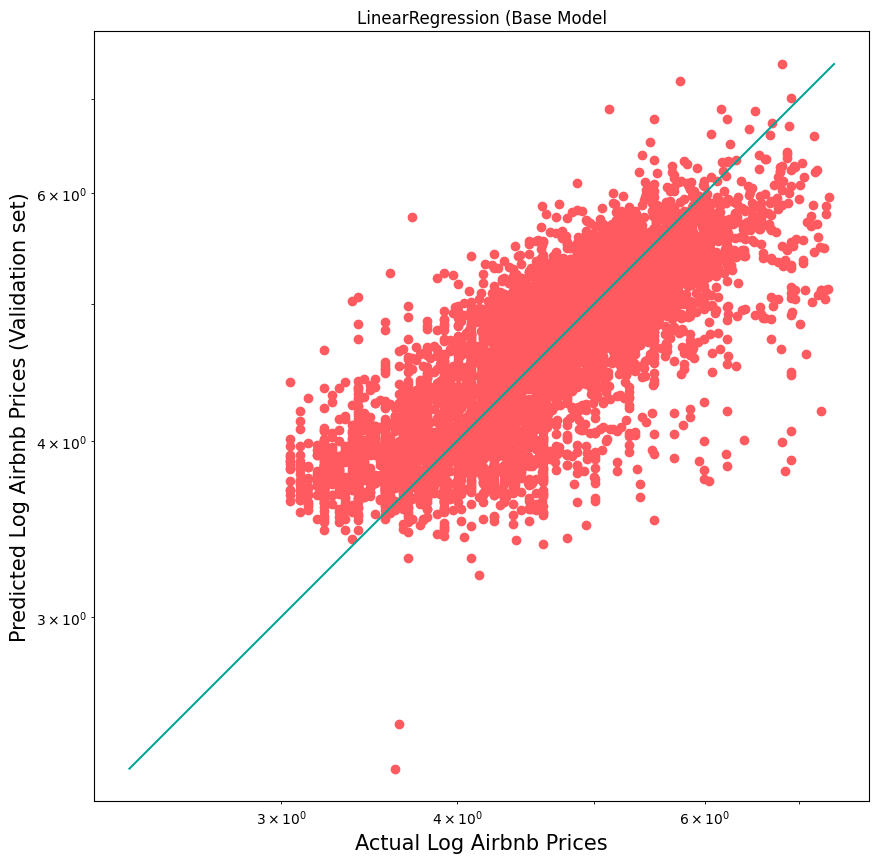

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(y_val_reference, prediction, color = '#FF5A5F')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_val_reference))
p2 = min(min(prediction), min(y_val_reference))
plt.plot([p1, p2], [p1, p2], '#00A699')
plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
plt.axis('equal')
plt.title("LinearRegression (Base Model")


**Adding more Complexity - Other Modelling Techniques - Default parameters on Validation set**

  0%|          | 0/8 [00:00<?, ?it/s]

Ridge(random_state=44) RMSE: 0.4840919571304316
Ridge(random_state=44) R^2: 0.6156738098196364
-------------------------------


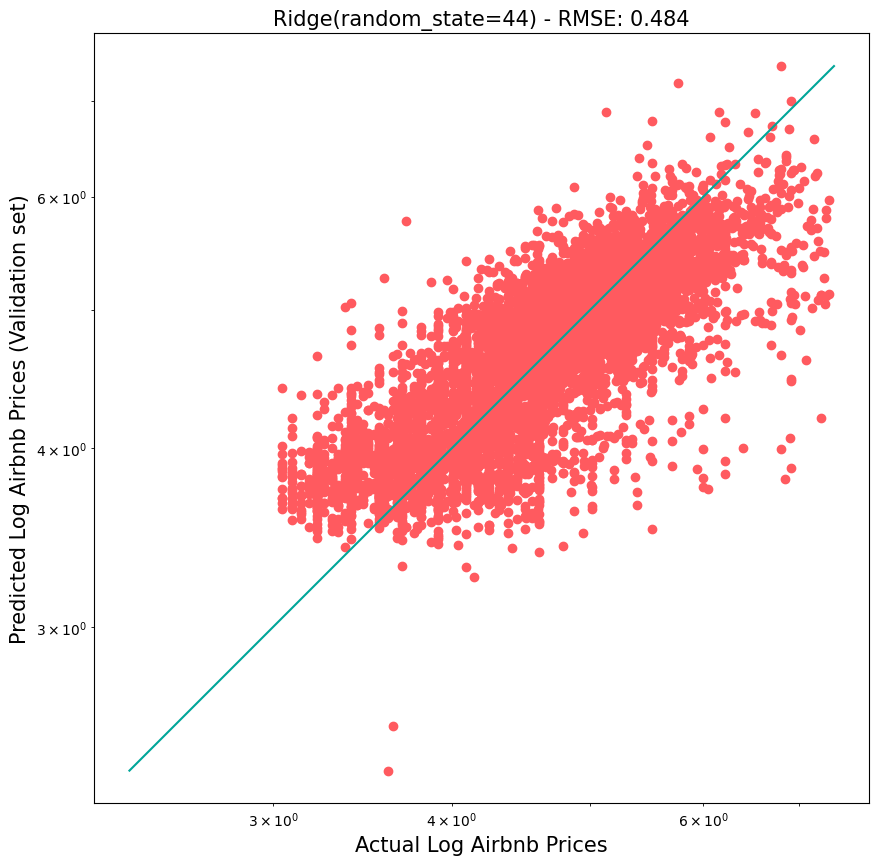

 12%|█▎        | 1/8 [00:03<00:26,  3.73s/it]

DecisionTreeRegressor(random_state=44) RMSE: 0.6352347004313856
DecisionTreeRegressor(random_state=44) R^2: 0.33822146857755186
-------------------------------


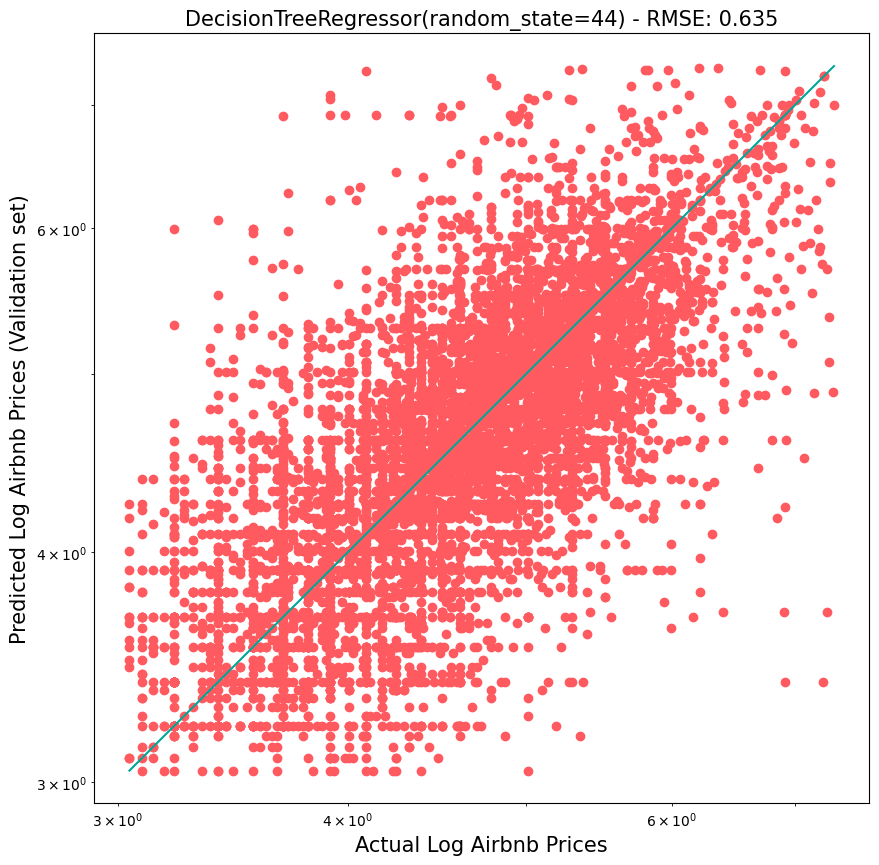

 25%|██▌       | 2/8 [00:06<00:19,  3.31s/it]

BaggingRegressor(random_state=44) RMSE: 0.4642736598032723
BaggingRegressor(random_state=44) R^2: 0.6464976245980617
-------------------------------


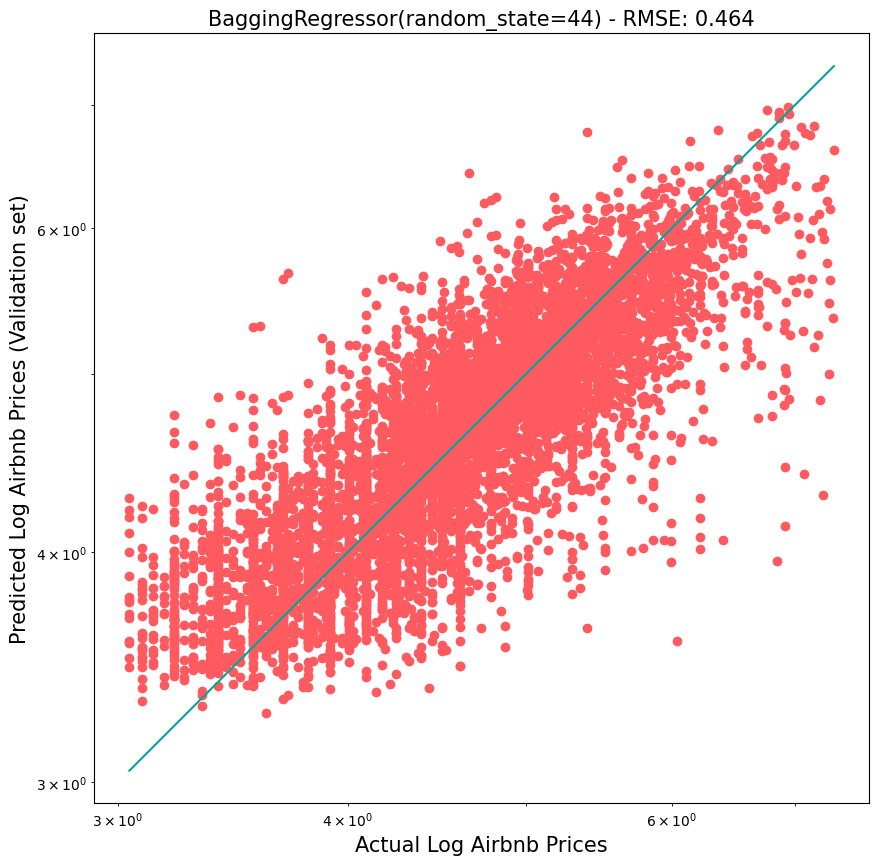

 38%|███▊      | 3/8 [00:17<00:32,  6.55s/it]

RandomForestRegressor(random_state=44) RMSE: 0.44290700645898395
RandomForestRegressor(random_state=44) R^2: 0.6782864540561477
-------------------------------


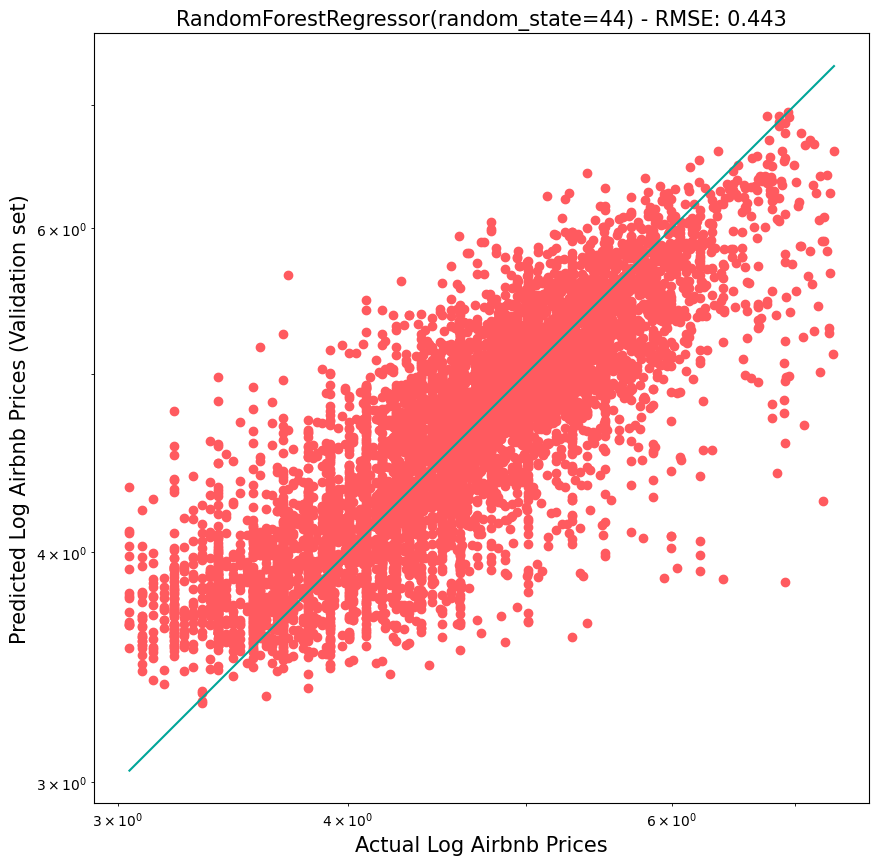

 50%|█████     | 4/8 [01:56<02:53, 43.36s/it]

ExtraTreesRegressor(random_state=44) RMSE: 0.4497949376140988
ExtraTreesRegressor(random_state=44) R^2: 0.6682022987725009
-------------------------------


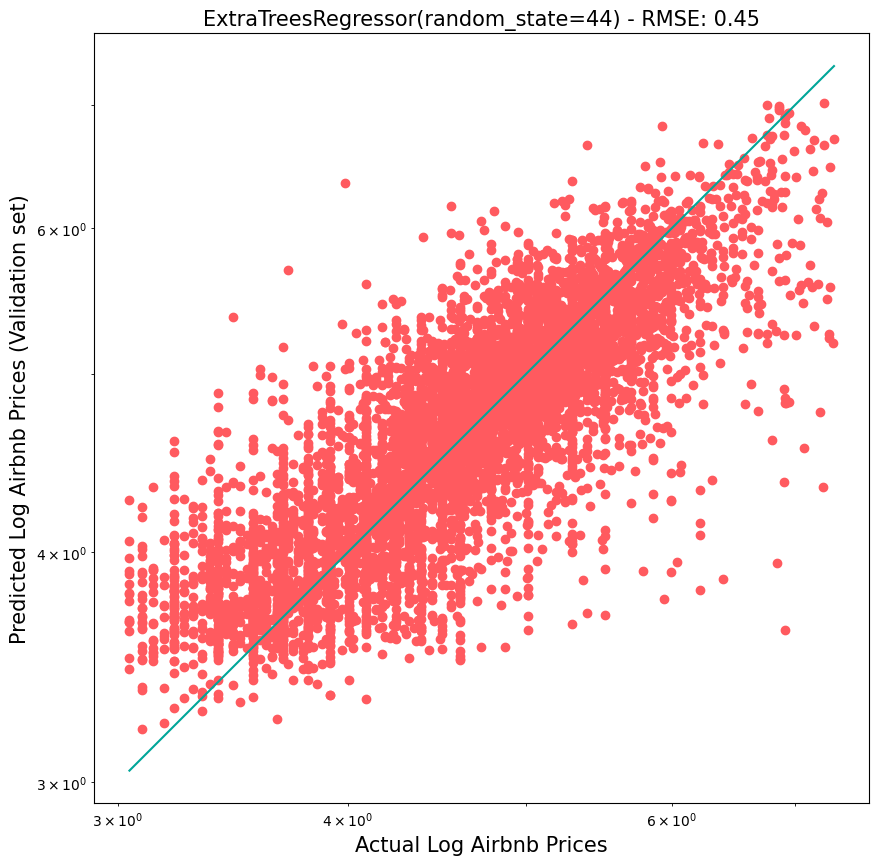

 62%|██████▎   | 5/8 [03:29<03:03, 61.13s/it]

AdaBoostRegressor(random_state=44) RMSE: 0.6584926843443983
AdaBoostRegressor(random_state=44) R^2: 0.28887465856067207
-------------------------------


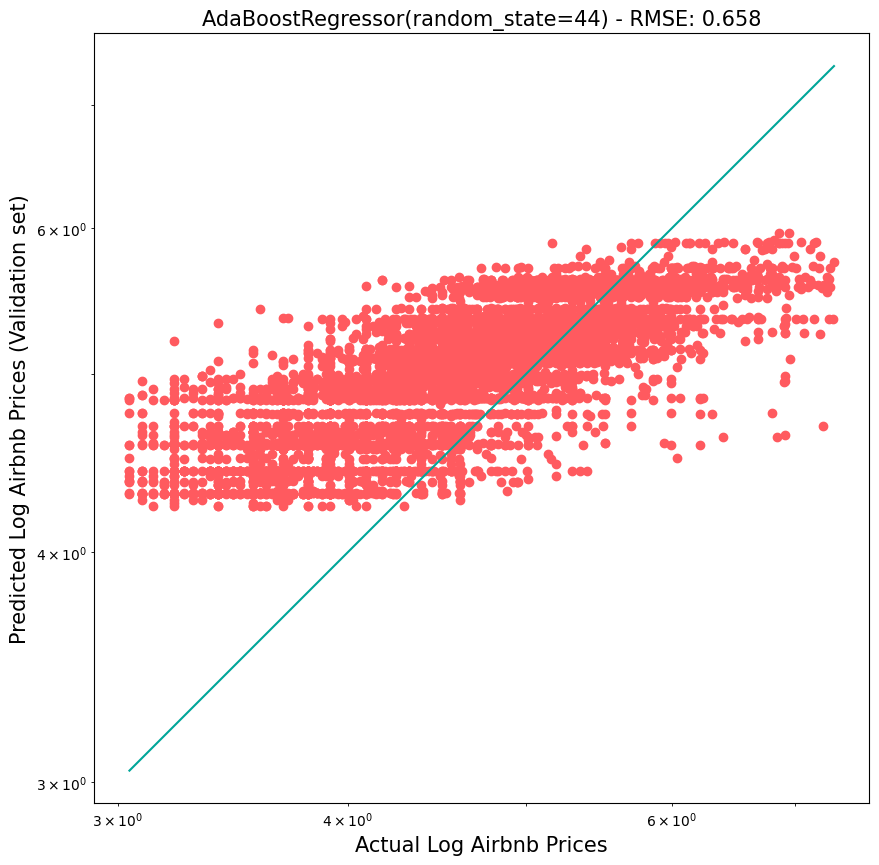

 75%|███████▌  | 6/8 [03:57<01:39, 49.90s/it]

LGBMRegressor(random_state=44) RMSE: 0.4445798913744681
LGBMRegressor(random_state=44) R^2: 0.6758516037744632
-------------------------------


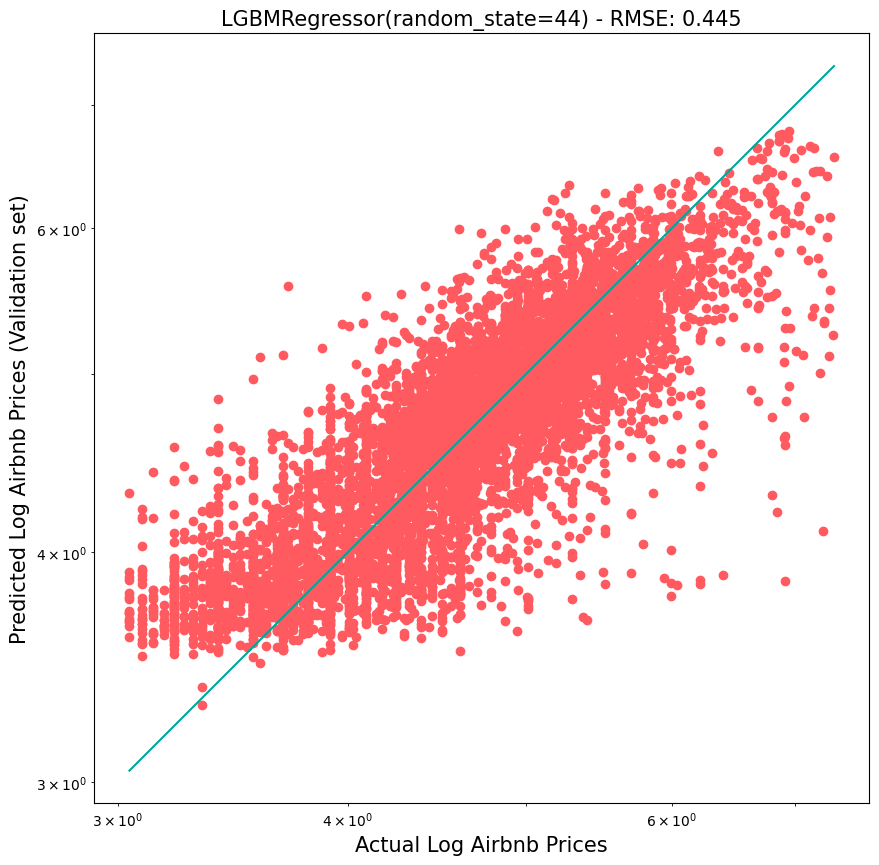

 88%|████████▊ | 7/8 [03:59<00:34, 34.13s/it]

KNeighborsRegressor() RMSE: 0.5043187333569538
KNeighborsRegressor() R^2: 0.5828863063003547
-------------------------------


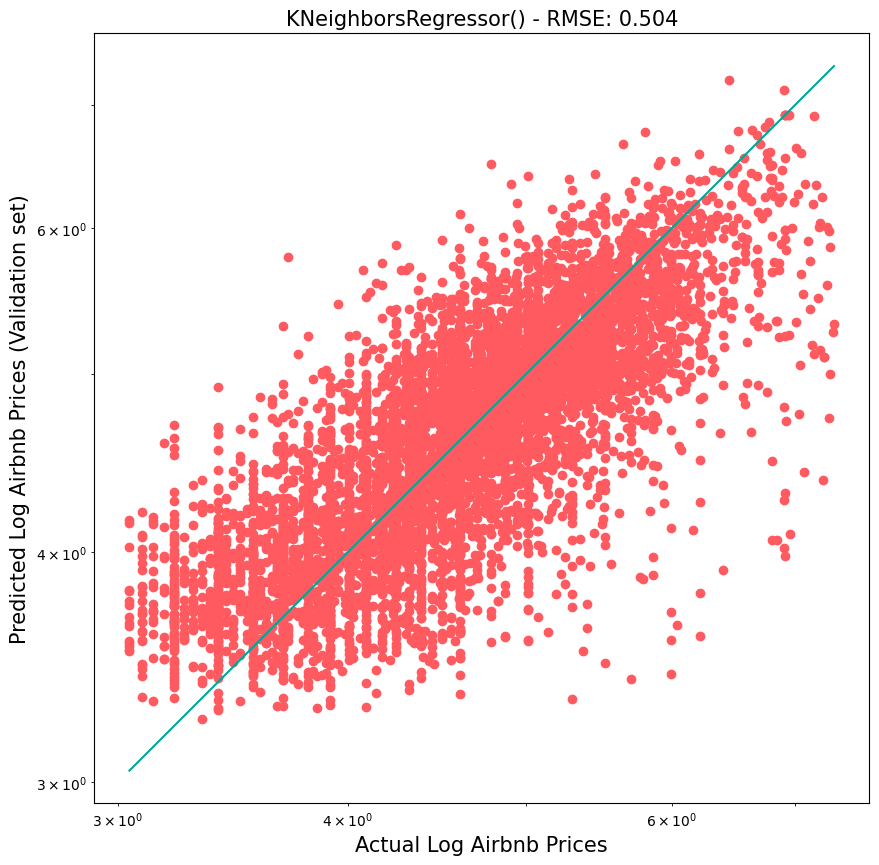

100%|██████████| 8/8 [04:05<00:00, 30.64s/it]


In [52]:
model_names = ['RidgeRegression',
               'DecisionTreeRegressor',
               'BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'AdaBoostRegressor',
               'LGBMRegressor',
               'KNeighborsRegressor']


model_list =  [Ridge(random_state = RANDOM_SEED),
               DecisionTreeRegressor(random_state = RANDOM_SEED), 
               BaggingRegressor(random_state = RANDOM_SEED), 
               RandomForestRegressor(random_state = RANDOM_SEED),
               ExtraTreesRegressor(random_state = RANDOM_SEED),
               AdaBoostRegressor(random_state = RANDOM_SEED),
               lightgbm.LGBMRegressor(random_state = RANDOM_SEED),
               KNeighborsRegressor(n_neighbors=5)]
              
rmse_list = []
r_square_list = []

for model in tqdm(model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)

  # RMSE Caculation and append to list
  rmse_list.append(np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))

  # R-square Caculation and append to list
  r_square = r2_score(y_val, prediction)
  r_square_list.append(r_square)
  print(str(model), "R^2:", r_square)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_val, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_val))
  p2 = min(min(prediction), min(y_val))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + " - RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_val, prediction)), 3)), fontsize=15)
  plt.show()

In [21]:
# add linear regression result to both lists
model_names.insert(0, "LinearRegression (Base Model)")
rmse_list.insert(0, rmse_linearreg)
r_square_list.insert(0, r_square_linearreg)

In [ ]:
# plotting results of classifiers on default hyperparameters
df_plot = pd.DataFrame()
df_plot['Model Names'] = model_names
df_plot['RMSE'] = rmse_list
df_plot['R-square'] = r_square_list
df_plot

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-f1ce283c2b2b>", line 4, in <cell line: 4>
    df_plot['RMSE'] = rmse_list
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py", line 3655, in __setitem__
    self._set_item(key, value)
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py", line 3832, in _set_item
    value = self._sanitize_column(value)
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py", line 4538, in _sanitize_column
    com.require_length_match(value, self.index)
  File "/usr/local/lib/python3.9/dist-packages/pandas/core/common.py", line 557, in require_length_match
    raise ValueError(
ValueError: Length of values (9) does not match length of index (4)

During handling of the above exception, another exception occurred:

Traceback (most recent call la

Text(0.5, 1.0, 'Scores on validation set - default hyperparameters')

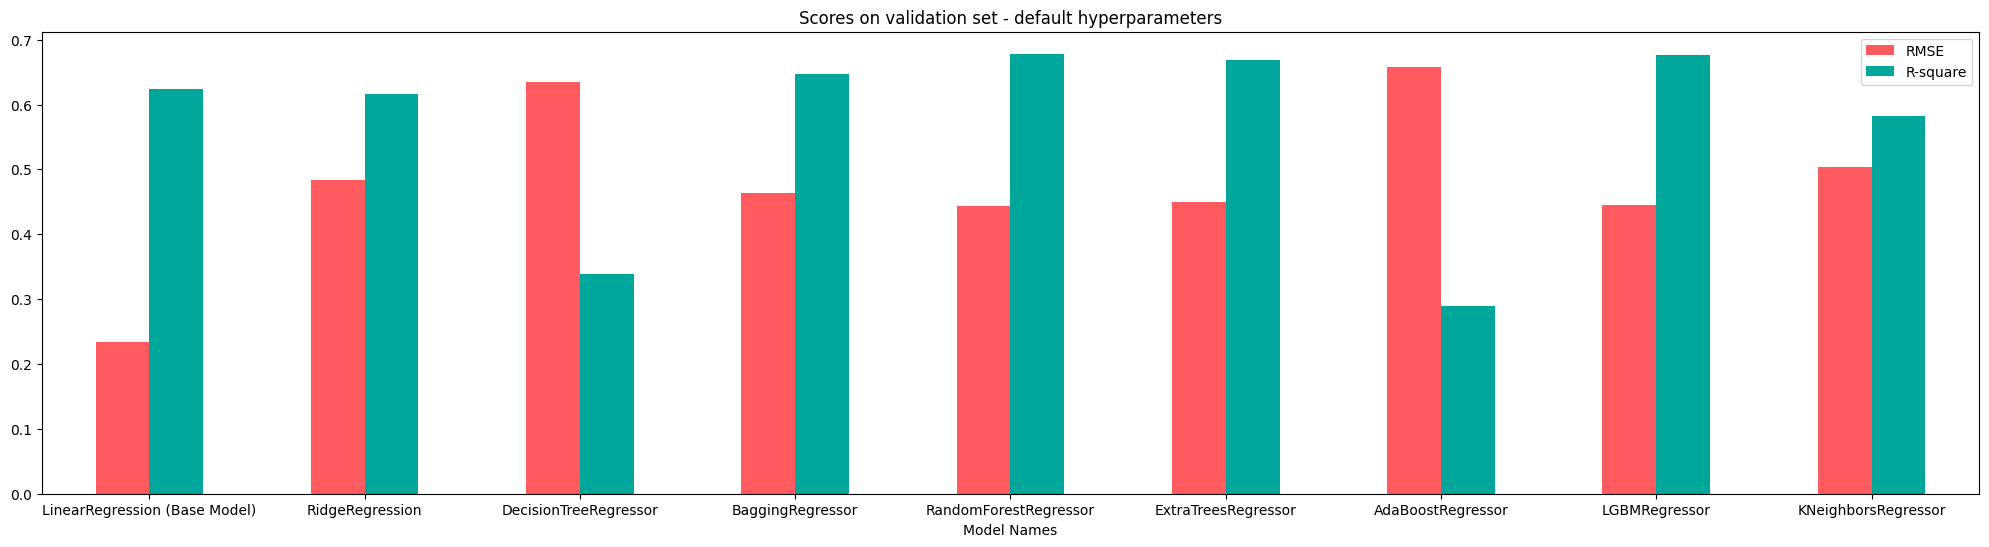

In [24]:
# plot the results
df_plot = df_plot.set_index('Model Names') # set index for x axis
df_plot[['RMSE', 'R-square']].plot(kind='bar', figsize=(25,6), color=['#FF5A5F', '#00A699'])
plt.xticks(rotation = 0)
plt.title("Scores on validation set - default hyperparameters")

**Hyperparameter Tuning on train set**

In [14]:
# Helper function: Source - https://www.davidsbatista.net/blog/2018/02/23/model_optimization/

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

We decided we pick the top 4 emsemble techniques that have the lowest RMSE to compare against the baseline model. Hence, hyperparameter tuning was performed on the following 4 algorithms. 

In [15]:
%%time
model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']

model_list =  [BaggingRegressor(random_state = RANDOM_SEED), 
               RandomForestRegressor(random_state = RANDOM_SEED),
               ExtraTreesRegressor(random_state = RANDOM_SEED),
               lightgbm.LGBMRegressor(random_state = RANDOM_SEED)]  

# convert the two lists into a dictionary
dict_model = {model_names[i]: model_list[i] for i in range(len(model_list))}

# the optimisation parameters for each of the above models
params = {'BaggingRegressor': {'n_estimators': [5, 15 , 20, 50, 200]},
          
          'RandomForestRegressor': {'n_estimators': [5, 15 , 20, 50, 200],
                                    'max_features': ['auto', 'sqrt'],
                                    'max_depth': [None, 1, 3, 5, 12]},
          
          'ExtraTreesRegressor': {'n_estimators': [5, 15, 20, 50, 200],
                                  'max_features': ['auto', 'sqrt'],
                                  'max_depth': [None, 1, 3, 5, 12]},
          
          'LGBMRegressor': {'n_estimators': [5, 15, 20, 50, 200],
                            'num_leaves ': [31, 10, 20, 50, 60, 100],
                            'max_depth': [None, 1, 3, 5, 12]}}

helper = EstimatorSelectionHelper(dict_model, params)
helper.fit(X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=2)

Running GridSearchCV for BaggingRegressor.
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Running GridSearchCV for LGBMRegressor.
Fitting 3 folds for each of 150 candidates, totalling 450 fits
CPU times: user 23.5 s, sys: 3.1 s, total: 26.6 s
Wall time: 49min 57s


In [16]:
df_scores = helper.score_summary(sort_by='mean_score')
df_scores

BaggingRegressor
RandomForestRegressor
ExtraTreesRegressor
LGBMRegressor


estimator min_score mean_score max_score std_score  \
254          LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178   
253          LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178   
252          LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178   
251          LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178   
250          LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178   
..                     ...       ...        ...       ...       ...   
21   RandomForestRegressor -0.519652  -0.518025 -0.516634  0.001243   
23   RandomForestRegressor -0.534673  -0.518133 -0.505092  0.012327   
22   RandomForestRegressor -0.530859  -0.519677 -0.513197   0.00794   
70     ExtraTreesRegressor   -0.5374  -0.532594 -0.525417  0.005171   
20   RandomForestRegressor -0.568063  -0.535805  -0.48562  0.035965   

    n_estimators max_depth max_features num_leaves   
254          200        12          NaN         100  
253          200        12          NaN          60  
252          200        12          NaN          50  
251          200        12          NaN          20  
250          200        12          NaN          10  
..           ...       ...          ...         ...  
21            15         1         sqrt         NaN  
23            50         1         sqrt         NaN  
22            20         1         sqrt         NaN  
70             5         1         sqrt         NaN  
20             5         1         sqrt         NaN  

[255 rows x 9 columns]

In [25]:
for estima in np.unique(df_scores.estimator):
  df_i = df_scores[df_scores['estimator'] == estima].head(1)
  print(df_i)

          estimator min_score mean_score max_score std_score n_estimators  \
4  BaggingRegressor -0.212078  -0.210847 -0.209272  0.001171          200   

  max_depth max_features num_leaves   
4       NaN          NaN         NaN  
              estimator min_score mean_score max_score std_score n_estimators  \
64  ExtraTreesRegressor -0.218082   -0.21571  -0.21365  0.001823          200   

   max_depth max_features num_leaves   
64      None         sqrt         NaN  
         estimator min_score mean_score max_score std_score n_estimators  \
254  LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178          200   

    max_depth max_features num_leaves   
254        12          NaN         100  
                estimator min_score mean_score max_score std_score  \
14  RandomForestRegressor -0.209556  -0.207442 -0.205706  0.001595   

   n_estimators max_depth max_features num_leaves   
14          200      None         sqrt         NaN  


**Tuned models on Validation set**

  0%|          | 0/4 [00:00<?, ?it/s]

BaggingRegressor(n_estimators=200, random_state=44) RMSE: 0.441271550907416
BaggingRegressor(n_estimators=200, random_state=44) R^2: 0.6806579531890032
-------------------------------


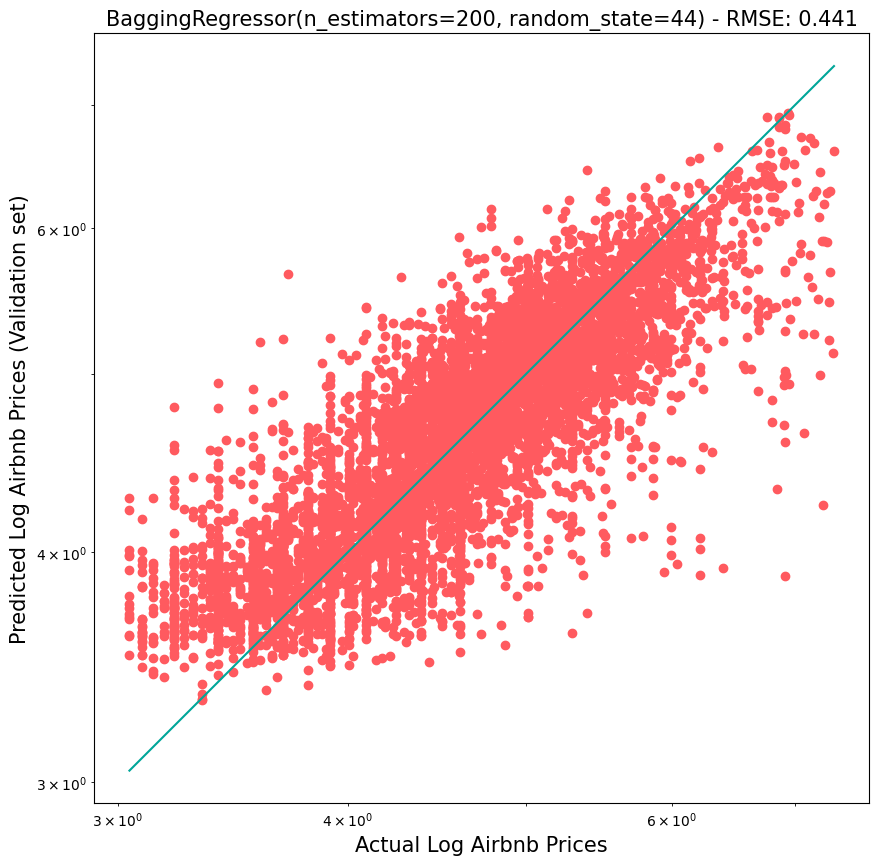

 25%|██▌       | 1/4 [03:33<10:40, 213.39s/it]

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.4419658862459542
RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6796522010039686
-------------------------------


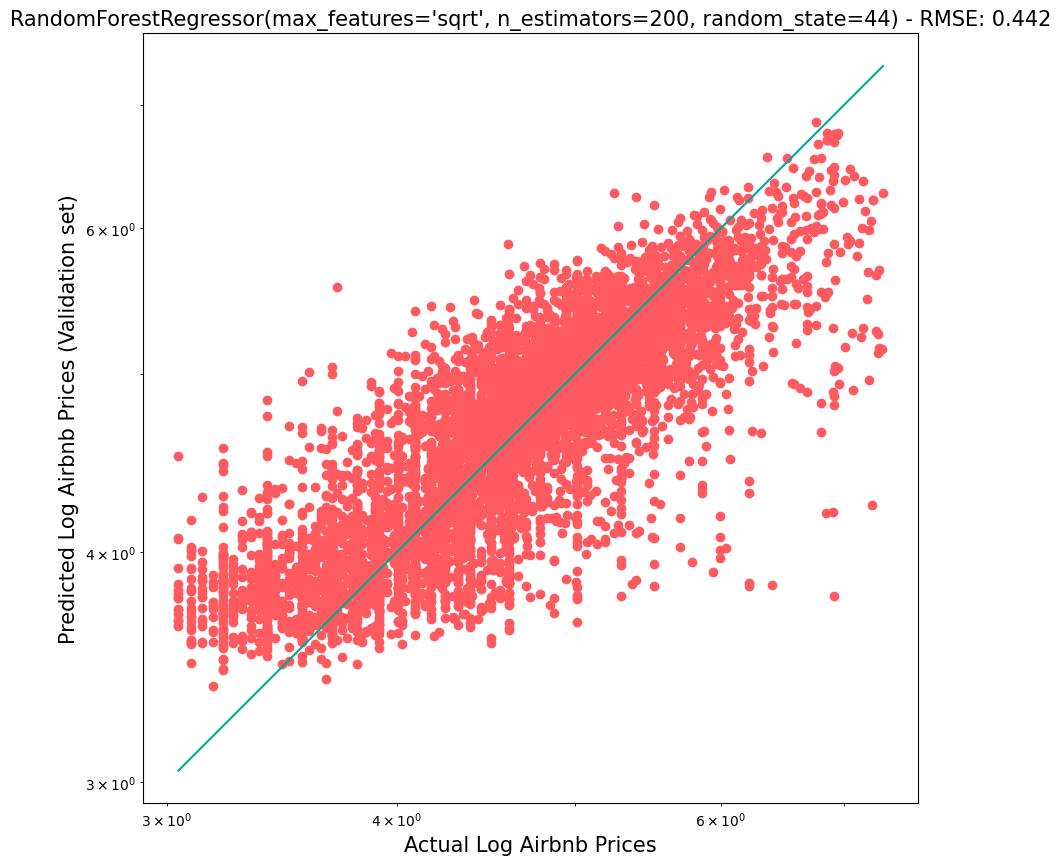

 50%|█████     | 2/4 [04:18<03:49, 114.59s/it]

ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.44955134628665033
ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6685615787484708
-------------------------------


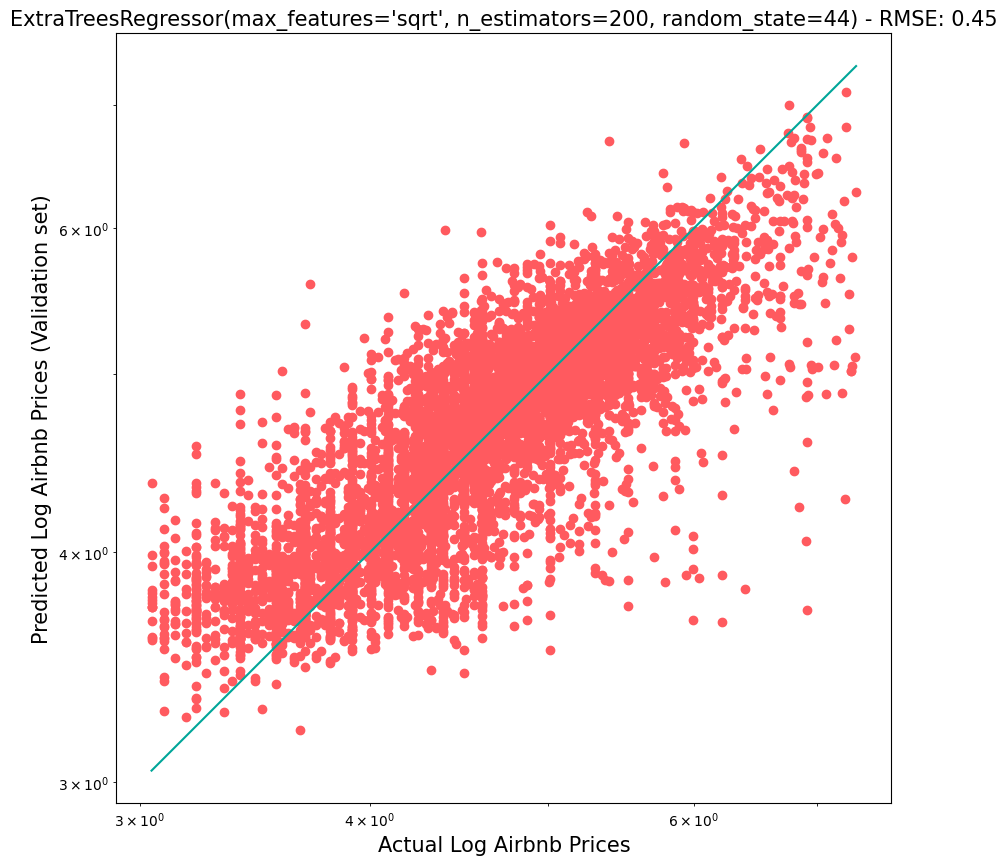

 75%|███████▌  | 3/4 [05:04<01:23, 83.19s/it] 

LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) RMSE: 0.4334276319028162
LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) R^2: 0.6919101175613093
-------------------------------


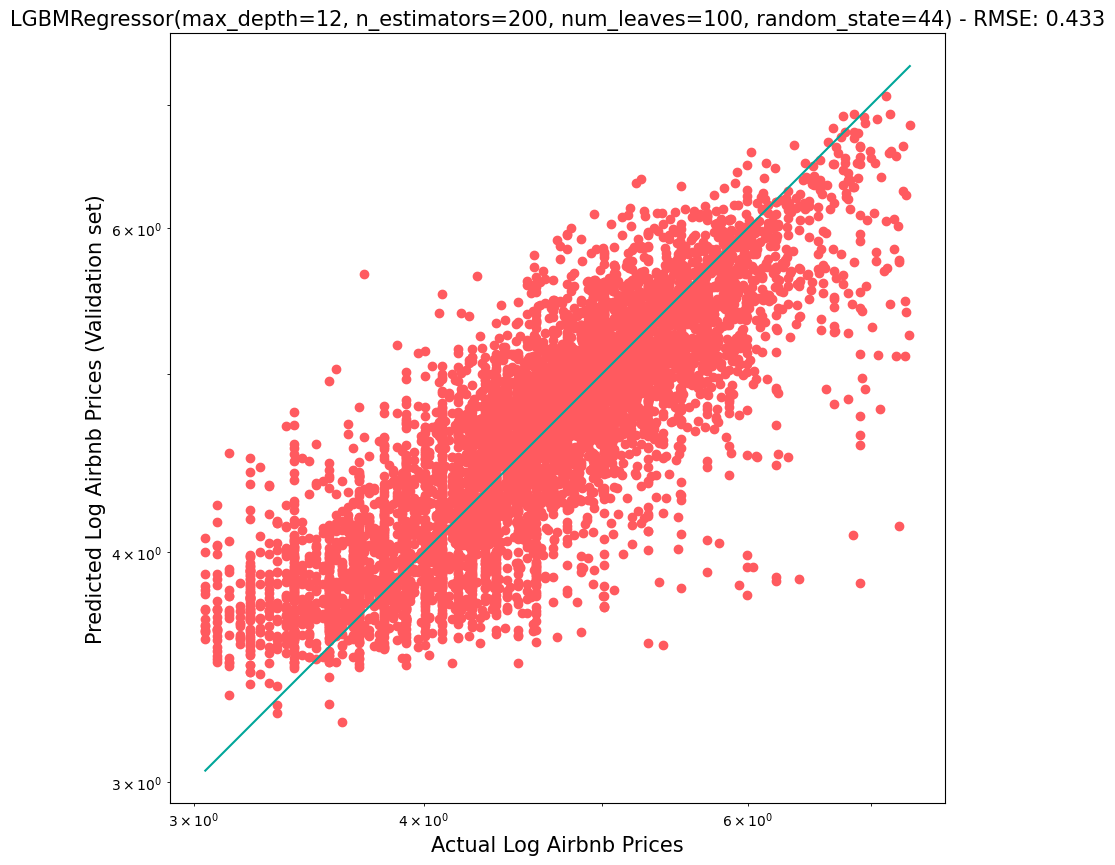

100%|██████████| 4/4 [05:07<00:00, 76.82s/it]


In [18]:
# best hyperparameters for each model
tuned_model_list =  [BaggingRegressor(n_estimators = 200, random_state = RANDOM_SEED), 
                     RandomForestRegressor(n_estimators = 200, max_features = 'sqrt', max_depth = None, random_state = RANDOM_SEED),
                     ExtraTreesRegressor(n_estimators = 200, max_features = 'sqrt', random_state = RANDOM_SEED),
                     lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED)]

model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']

tuned_rmse_list = []
tuned_r_square_list = []

for model in tqdm(tuned_model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)

  # RMSE Caculation and append to list
  tuned_rmse_list.append(np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))

  # R-square Caculation and append to list
  r_square = r2_score(y_val, prediction)
  tuned_r_square_list.append(r_square)
  print(str(model), "R^2:", r_square)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_val, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_val))
  p2 = min(min(prediction), min(y_val))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + " - RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_val, prediction)), 3)), fontsize=15)
  plt.show()

In [27]:
# plotting results of classifiers on tuned hyperparameters on validation set

model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']


df_plot = pd.DataFrame()
df_plot['Model Names'] = model_names
df_plot['RMSE (Tuned)'] = tuned_rmse_list
df_plot['R-square (Tuned)'] = tuned_r_square_list
df_plot = df_plot.set_index('Model Names')
df_plot.reset_index()

Model Names  RMSE (Tuned)  R-square (Tuned)
0       BaggingRegressor      0.441272          0.680658
1  RandomForestRegressor      0.441966          0.679652
2    ExtraTreesRegressor      0.449551          0.668562
3          LGBMRegressor      0.433428          0.691910

**Out of Sample (Test set results) - Baseline Model and 4 tuned models**

In [28]:
# initialise the linear regression model
model = sm.OLS(y_train_reference, X_train_reference).fit()
print(model.summary())
print("The Durbin Watson test statistic is",  durbin_watson(model.resid), "Since this is within the range of 1.5 and 2.5, autocorrelation is not an issue this regression model.")

# prediction
prediction = model.predict(X_test_reference)
rmse_linearreg = mean_squared_error(y_test_reference, prediction)
print("RMSE:", rmse_linearreg)
r_square_linearreg = model.rsquared_adj
print("R^2:", r_square_linearreg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     660.4
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        06:22:51   Log-Likelihood:                -38704.
No. Observations:               55188   AIC:                         7.769e+04
Df Residuals:                   55048   BIC:                         7.894e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Bark

  0%|          | 0/4 [00:00<?, ?it/s]

BaggingRegressor(n_estimators=200, random_state=44) RMSE: 0.447185819794028
BaggingRegressor(n_estimators=200, random_state=44) R^2: 0.6886095746194716
-------------------------------


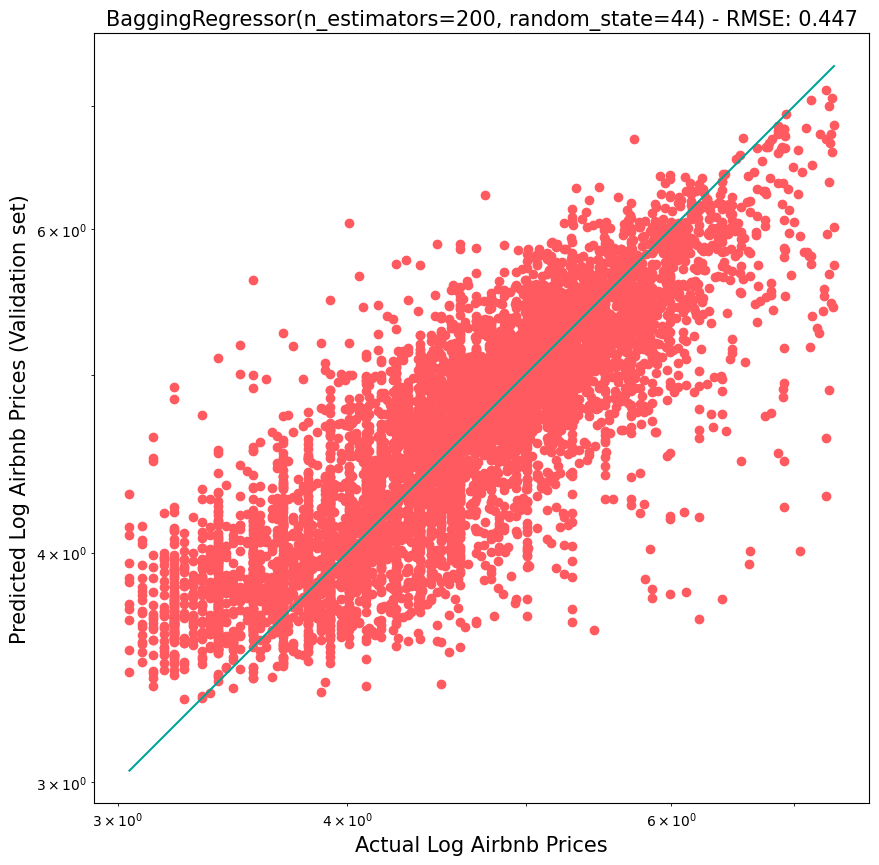

 25%|██▌       | 1/4 [03:14<09:42, 194.12s/it]

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.44756640586972274
RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6880793194761836
-------------------------------


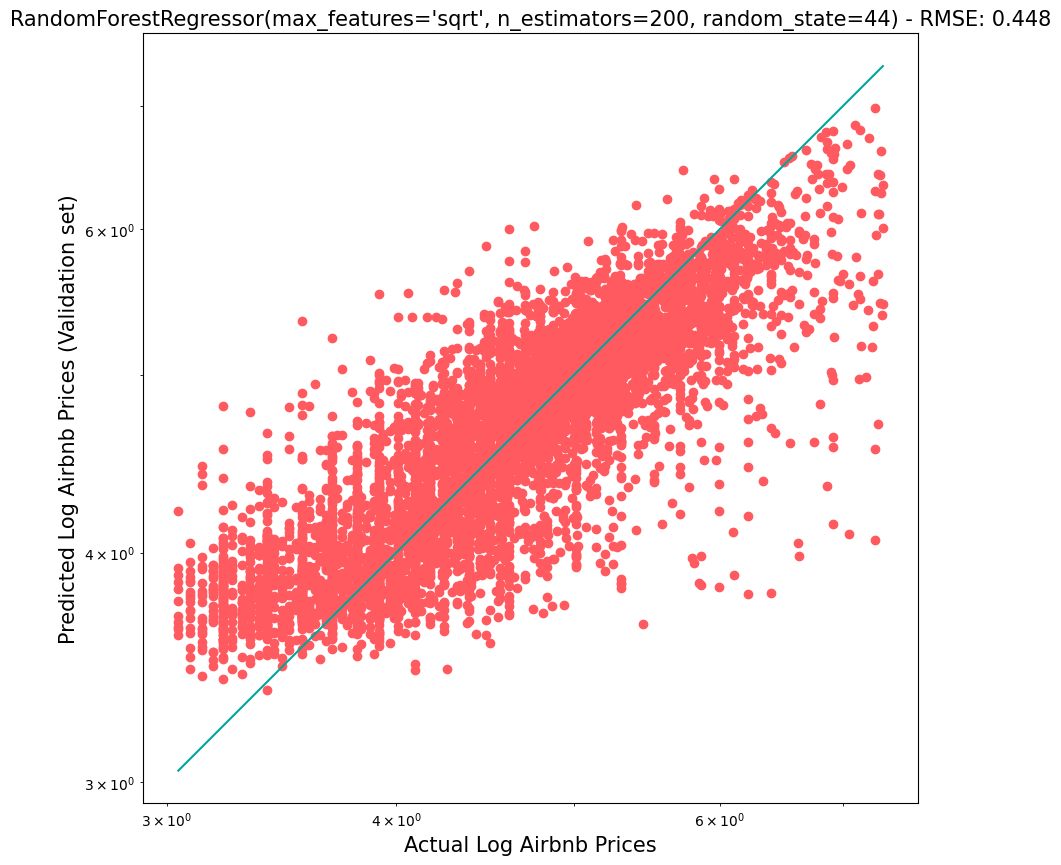

 50%|█████     | 2/4 [03:54<03:26, 103.42s/it]

ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.4536079309331126
ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6796014914123681
-------------------------------


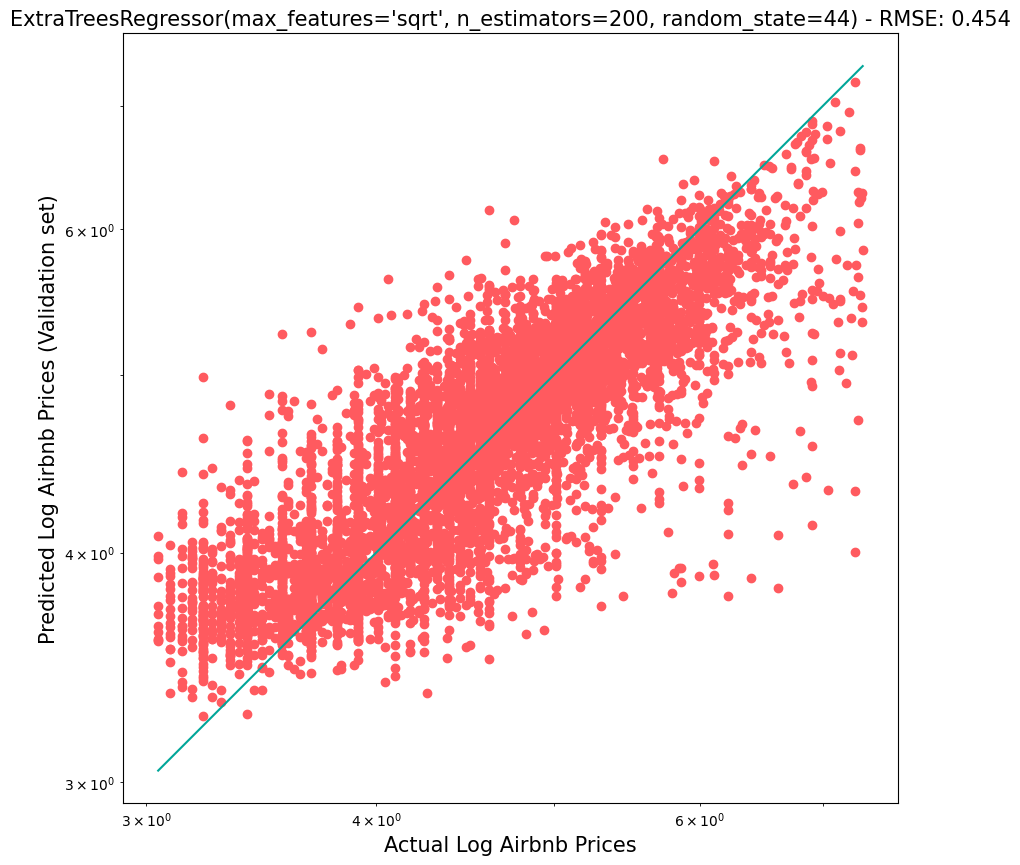

 75%|███████▌  | 3/4 [04:37<01:15, 75.92s/it] 

LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) RMSE: 0.44042851709279185
LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) R^2: 0.697949144800869
-------------------------------


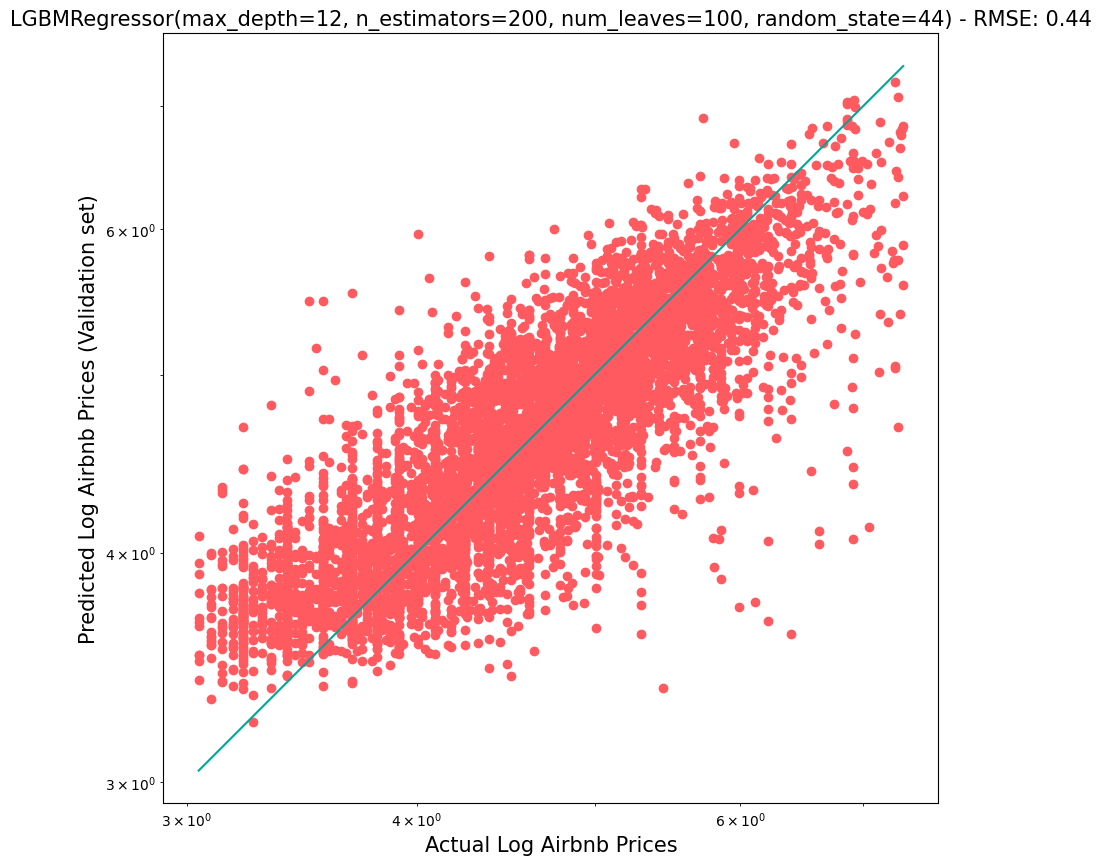

100%|██████████| 4/4 [04:39<00:00, 69.98s/it]


In [29]:
test_rmse_list = []
test_r_square_list = []

for model in tqdm(tuned_model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)

  # RMSE Caculation and append to list
  test_rmse_list.append(np.sqrt(mean_squared_error(y_test, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_test, prediction)))

  # R-square Caculation and append to list
  r_square = r2_score(y_test, prediction)
  test_r_square_list.append(r_square)
  print(str(model), "R^2:", r_square)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_test, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_test))
  p2 = min(min(prediction), min(y_test))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + " - RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_test, prediction)), 3)), fontsize=15)
  plt.show()

In [30]:
test_model_names = ['BaggingRegressor',
                    'RandomForestRegressor',
                    'ExtraTreesRegressor',
                    'LGBMRegressor']
                    
                    
# add linear regression result to both lists
test_model_names.insert(0, "LinearRegression (Base Model)")
test_rmse_list.insert(0, rmse_linearreg)
test_r_square_list.insert(0, r_square_linearreg)
# plotting results of classifiers on default hyperparameters
df_plot = pd.DataFrame()
               
df_plot['Model Names'] = test_model_names
df_plot['RMSE'] = test_rmse_list
df_plot['R-square'] = test_r_square_list
df_plot = df_plot.set_index('Model Names')
df_plot.reset_index()

Model Names      RMSE  R-square
0  LinearRegression (Base Model)  0.238903  0.624174
1               BaggingRegressor  0.447186  0.688610
2          RandomForestRegressor  0.447566  0.688079
3            ExtraTreesRegressor  0.453608  0.679601
4                  LGBMRegressor  0.440429  0.697949

**Feature Importance for LGBMRegressor using Sharpely values**

**Row = 50**

In [46]:
%%time
shap.initjs()

i = 50
model = lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features = X_train.iloc[i], 
                feature_names = X_train.columns,
                plot_cmap = ['#00A699','#FF5A5F'])

CPU times: user 13min 2s, sys: 908 ms, total: 13min 3s
Wall time: 7min 52s


**row = 500**

In [36]:
%%time
shap.initjs()

i = 500
model = lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features = X_train.iloc[i], 
                feature_names = X_train.columns,
                plot_cmap = ['#00A699','#FF5A5F'])

CPU times: user 12min 58s, sys: 896 ms, total: 12min 59s
Wall time: 8min 3s


**row = 1500**

In [47]:
%%time
shap.initjs()

i = 1500
model = lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features = X_train.iloc[i], 
                feature_names = X_train.columns,
                plot_cmap = ['#00A699','#FF5A5F'])

CPU times: user 13min 1s, sys: 735 ms, total: 13min 1s
Wall time: 7min 44s


The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Note that this plot can only be made for one observation. For this example, I have taken the 4th observation.

**Summary plot**

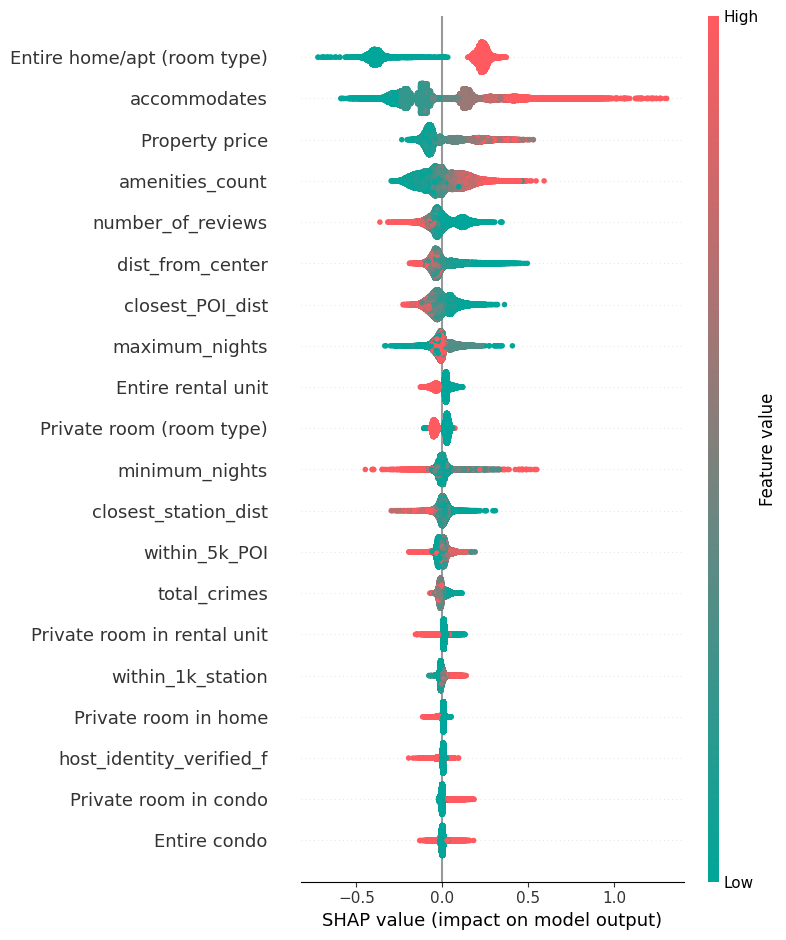

In [38]:
# Generate colormap through matplotlib
newCmap = LinearSegmentedColormap.from_list("", ['#00A699','#FF5A5F'])

shap.initjs()
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, cmap = newCmap)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

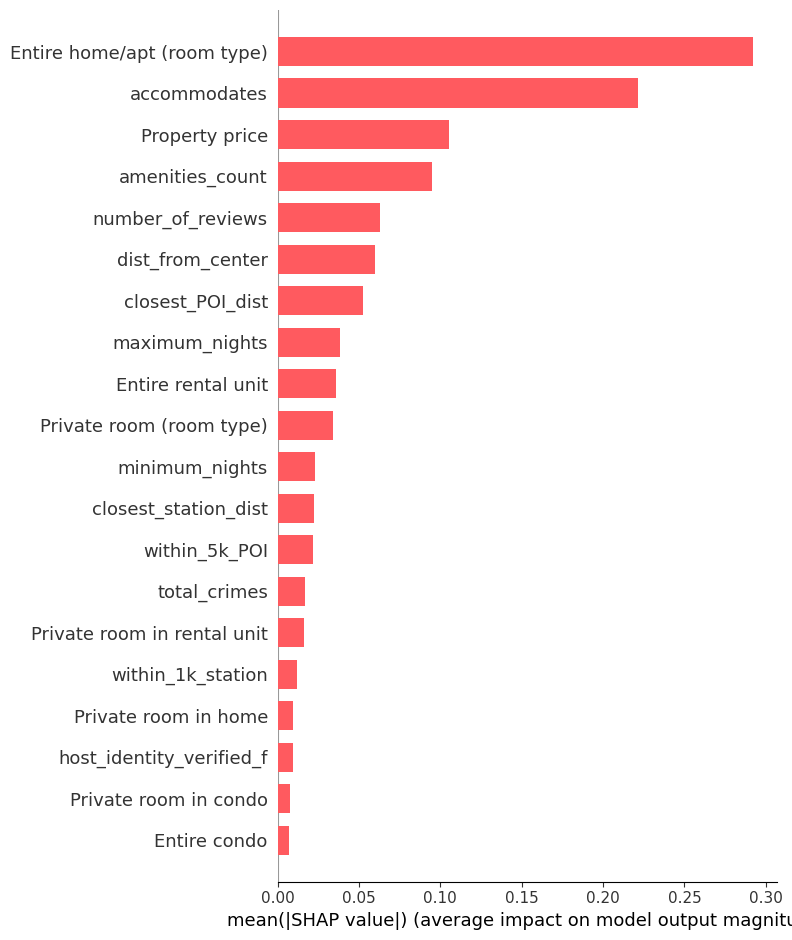

In [48]:
shap.initjs()
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, plot_type ='bar', color = '#FF5A5F')

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot